# Analysis

This notebook looks at the following:

1) Define and section the time period into more manageable periods to analyse / deep dive
2) Changes in sentiment over time
3) Does speech sentiment correlate to base rate changes
4) Predictive model attempt: can the sentiment of a speech predict the bas rate change?

This was to answer the business question: Does sentiment significantly change alongside macroeconomic indicators such as bank base rate and CPI?

## Technical notes

This notebook was created using:

* Python 3.11.5 | packaged by Anaconda, Inc.
* Juypter Notebook: 2.1.1
* Numpy version: 1.25.2
* Pandas version: 2.1.1
* Seaborn version: 0.13
* Plotly version: 5.9.0

Last run on 13/04/2024 by Emma Roberts and returned 0 warnings or errors.

## Library and Data import

In [1]:
# Imports
import numpy as np
import pandas as pd
import os
import warnings
import datetime

# Supress warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# Create user defined function for import and checking
def import_and_check(file_path):
    # Import limited to csv and xlsx given provided data
    data = (
        pd.read_csv(file_path) 
        if file_path.endswith('.csv') 
        else pd.read_excel(file_path))

    # Check for missing values
    missing_values = data.isnull().sum()

    # Display shape and data types
    print(data.shape)
    print(' ')
    print(data.dtypes)
    print(' ')
    
    # Display missing values
    print(missing_values)

    # Check for duplicate records
    duplicate_records = data[data.duplicated()]
    
    # Display duplicate records
    if not duplicate_records.empty:
        print('\nDuplicate Records:')
        display(duplicate_records)
    else:
        print('\nNo Duplicate Records Found.')

    # Display head and tail for headers, 
    # footers, and to confirm data loaded successfully
    display(data.head())
    display(data.tail())
    
    return data

In [3]:
# List all files in the working directory
files = ['all_data.csv']

# Create a dictionary to store dataframes
dataframes = {}

# Iterate over each file
for file_name in files:
    # Don't attempt to self-import the J-notebook!
    if not file_name.endswith('.ipynb'):
        # Remove the file extension
        name_without_extension = os.path.splitext(file_name)[0]
        print(f"\nSummary for file: {file_name}")
        # Import and check data, and store in the dictionary with the filename as key
        dataframes[name_without_extension] = import_and_check(file_name)

# Extract dataframes and assign them to individual variables
for df_name, df in dataframes.items():
    globals()[df_name] = df


Summary for file: all_data.csv
(6126, 33)
 
date                 object
reference            object
country              object
title                object
author               object
is_gov                 bool
word_count            int64
body                 object
central_bank         object
year                  int64
language             object
vader_polarity      float64
lm_polarity         float64
finbert_polarity    float64
boe_speech             bool
fed_speech             bool
fsr                    bool
mpr                    bool
ftse_250            float64
base_rate           float64
brent_price         float64
cpi                 float64
euro                float64
ftse_100            float64
gdp_million           int64
gold_price            int64
avg_house_price     float64
1_mo_bond           float64
10_yr_bond          float64
2_yr_bond           float64
unemployment        float64
usd                 float64
wage_growth         float64
dtype: object
 
date           

,date,reference,country,title,author,is_gov,word_count,body,central_bank,year,...,ftse_100,gdp_million,gold_price,avg_house_price,1_mo_bond,10_yr_bond,2_yr_bond,unemployment,usd,wage_growth
0,1999-01-04,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,5879.399902,255773,289,72903.17681,6.023,4.287,4.899,6.2,1.6585,NaN
1,1999-01-05,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,5958.200195,255773,289,72903.17681,6.022,4.330,4.895,6.2,1.6542,NaN
2,1999-01-06,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,6148.799805,255773,290,72903.17681,6.022,4.319,4.917,6.2,1.6549,NaN
3,1999-01-07,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,6101.200195,255773,293,72903.17681,6.022,4.277,4.941,6.2,1.6520,NaN
4,1999-01-08,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,6147.200195,255773,293,72903.17681,6.019,4.252,4.810,6.2,1.6423,NaN


,date,reference,country,title,author,is_gov,word_count,body,central_bank,year,...,ftse_100,gdp_million,gold_price,avg_house_price,1_mo_bond,10_yr_bond,2_yr_bond,unemployment,usd,wage_growth
6121,2022-10-14,r221012a_BOE,United Kingdom,Monetary policy: an anchor in challenging times,Pill,False,3567,BOE,Bank of England,2022,...,6858.799805,645805,1649,291193.0,2.208,4.323,3.877,3.8,1.1170,6.6
6122,2022-10-17,r221015a_BOE,United Kingdom,Monetary policy and financial stability interv...,Bailey,True,1767,BOE,Bank of England,2022,...,6920.200195,645805,1664,291193.0,2.106,3.981,3.559,3.8,1.1353,6.6
6123,2022-10-18,r221015a_BOE,United Kingdom,Monetary policy and financial stability interv...,Bailey,True,1767,BOE,Bank of England,2022,...,6936.700195,645805,1656,291193.0,2.329,3.943,3.547,3.8,1.1318,6.6
6124,2022-10-19,r221019a_BOE,United Kingdom,Governance of â€œDecentralisedâ€ Finance: Get...,Wilkins,False,5382,BOE,Bank of England,2022,...,6925.000000,645805,1634,291193.0,2.292,3.871,3.465,3.8,1.1214,6.6
6125,2022-10-20,r221020a_BOE,United Kingdom,The inflationary consequences of real shocks,Broadbent,False,6035,BOE,Bank of England,2022,...,6943.899902,645805,1637,291193.0,2.252,3.904,3.560,3.8,1.1233,6.6


In [4]:
# Convert combined_eco_data_1999_2022 'date' to datetime
all_data['date'] = pd.to_datetime(all_data['date'])

# Check
all_data.dtypes

date                datetime64[ns]
reference                   object
country                     object
title                       object
author                      object
is_gov                        bool
word_count                   int64
body                        object
central_bank                object
year                         int64
language                    object
vader_polarity             float64
lm_polarity                float64
finbert_polarity           float64
boe_speech                    bool
fed_speech                    bool
fsr                           bool
mpr                           bool
ftse_250                   float64
base_rate                  float64
brent_price                float64
cpi                        float64
euro                       float64
ftse_100                   float64
gdp_million                  int64
gold_price                   int64
avg_house_price            float64
1_mo_bond                  float64
10_yr_bond          

# 1) Defining the time periods

Want to section the time into periods of "similar" economic patterns. Base rate and Inflation (CPI) were selected as:

* Base rate is the key lever the BoE can pull to control inflation,
* Controlling inflation is one of the BoE objectives.

Therefore chosing time periods using these parameters should enable analysis and comparisons between periods to be conducted in a meaingful way for the business case.

### Period 1: 1999 – 1st June 2007

* Base rate fluctuated around 5%.
* CPI remained below 2% or started creeping up slightly with the onset of the Global Financial Crisis (GFC) in the USA in the second half of 2007. However, its impact was not yet fully seen in the UK.

### Period 2: 1st June 2007 – 31st Jan 2010

* The GFC hit the UK following the collapse of Lehman Brothers' bank.
* Base rate reduced from approximately 5% to 0.5% in response to Lehman Brothers' collapse in September 2008.
* CPI was brought back to target levels around 2%.
### Period 3: 31st Jan 2010 – 31st July 2012

* Aftermath of the GFC. Base rates remained at 0.5%.
* CPI remained above the 2% target.

### Period 4: 31st July 2012 – 23rd June 2016

* Base rates remained at 0.5%.
* CPI fell from slightly above 2% to approximately 0%.
* 23rd June 2016: Vote Leave.

### Period 5: 23rd June 2016 – 31st Dec 2019

* Small base rate increases, but it remained below 1%.
* CPI hovered around 2.5%.

### Period 6: 1st Jan 2020 – 30th July 2021

* The Covid Era and Brexit. The UK left the EU on 31st Jan 2020 and entered a transition period until 31st Dec 2020.
* Low CPI and low bank rates.

### Period 7: 30th July 2021 – Oct 2022

* CPI rapidly rose to 10%.
* Bank base rates steadily increased.


In [5]:
# Define the periods
periods = [
    ("Period 1", "1999", "2007-06-01"),
    ("Period 2", "2007-06-01", "2010-01-31"),
    ("Period 3", "2010-01-31", "2012-07-31"),
    ("Period 4", "2012-07-31", "2016-06-23"),
    ("Period 5", "2016-06-23", "2019-12-31"),
    ("Period 6", "2020-01-01", "2021-07-30"),
    ("Period 7", "2021-07-30", "2022-10-31")]

# Define key dates with labels
key_dates = {
    "Onset of GFC": "2007-06-01",
    "Lehman Brothers Collapse": "2008-09-15",
    "Brexit Vote": "2016-06-23",
    "COVID-19 & BREXIT": "2020-01-01",
    "Russia invades Ukraine": "2022-02-24",
    "Truss/Kwarteng Mini Budget": "2022-09-23",
    "Introduction of Euro": "1999-01-01",
    "Dot com bubble burst": "2000-01-01",
    "9/11": "2001-09-11"}

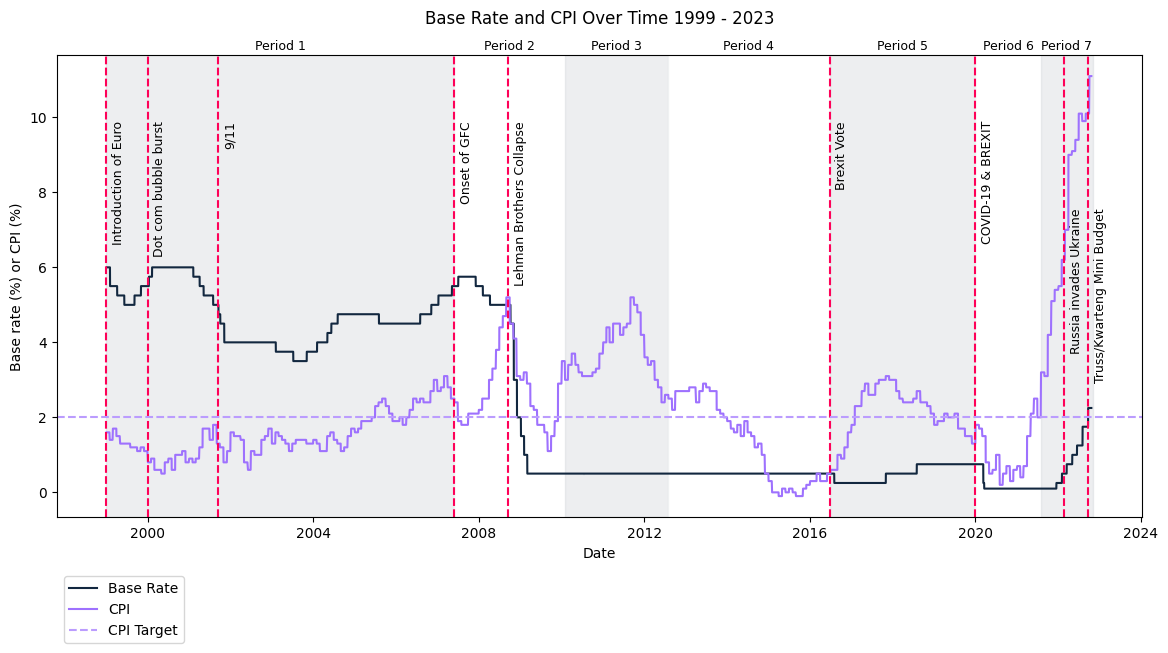

In [6]:
# Create line plots of base rate and CPI
plt.figure(figsize=(14, 6))
base_rate_plot = sns.lineplot(data=df, x='date',
                              y='base_rate',
                              color='#12273F',
                              label='Base Rate')
cpi_plot = sns.lineplot(data=df, x='date',
                        y='cpi', color='#9E71FE',
                        label='CPI')

# Shade and label the periods
for i, (period, start_date, end_date) in enumerate(periods):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    midpoint = start_date + (end_date - start_date) / 2
    color = '#C4C9CE' if i % 2 == 0 else 'white'
    plt.axvspan(start_date, end_date, color=color, alpha=0.3)
    
    # Adjust y-coordinate for all periods
    y_coord = plt.gca().get_ylim()[1] * 1.02  # Move to the top of the plot
    plt.text(midpoint, y_coord, period,
             horizontalalignment='center',
             verticalalignment='center', fontsize=9)

for label, date in key_dates.items():
    date = pd.to_datetime(date)
    if label in ["Russia invades Ukraine", "Truss/Kwarteng Mini Budget"]:
        plt.axvline(date, color='#FE0158', linestyle='--')
        plt.text(x=date + pd.DateOffset(days=50),
                 y=plt.gca().get_ylim()[1] * 0.65,
                 s=label, rotation=90,
                 verticalalignment='top', fontsize=9)
    else:
        plt.axvline(date, color='#FE0158', linestyle='--')
        plt.text(x=date + pd.DateOffset(days=50),
                 y=plt.gca().get_ylim()[1] * 0.85,
                 s=label, rotation=90,
                 verticalalignment='top', fontsize=9)

# Add a dashed line for CPI target and include it in the legend
plt.axhline(y=2, color='#BB9CFE',
            linestyle='--',
            label='CPI Target')

# Add legend outside
plt.legend(loc='center left',
           bbox_to_anchor=(0, -0.2))

# Label plot
plt.xlabel('Date')
plt.ylabel('Base rate (%) or CPI (%)')
plt.title('Base Rate and CPI Over Time 1999 - 2023',
          y=1.05)

# Save figure
plt.savefig('base_rate_cpi_over_time.png',
            bbox_inches='tight')

# Show
plt.show()

###

* There are two broad time periods:
 * pre-GFC, pre-2008: c.5% base rate, c.2% inflation
 * post-GFC, post-2010: c.0.5% base rate, variable inflation
* The impact of other key global events such as BREXIT, COVID and Russia invading Ukraine can clearly be seen.

Focussing on Period 2 in more detail may be of use as there are changes in base rate and inflation... It might be expected to see changes in speech sentiment in this period.


# 2) Sentiment over time

Let's look at how the sentiment for finBERT changes in each of these periods.

Firstly calculate quarterly rolling average of the sentiments to make it smoother.

In [7]:
# Set 'date' column as the index
df.set_index('date', inplace=True)

# Fill missing values with 0 before calculating rolling mean
df['finbert_polarity'] = df['finbert_polarity'].fillna(0)

# Assign the calculated monthly rolling averages to new columns
df['finbert_rolling_avg'] = df['finbert_polarity'].rolling(window=3*28, min_periods=1).mean()

# Print the updated DataFrame
df.reset_index(inplace=True)
df.head()

,date,reference,country,title,author,is_gov,word_count,body,central_bank,year,...,gdp_million,gold_price,avg_house_price,1_mo_bond,10_yr_bond,2_yr_bond,unemployment,usd,wage_growth,finbert_rolling_avg
0,1999-01-04,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,255773,289,72903.17681,6.023,4.287,4.899,6.2,1.6585,NaN,-0.007072
1,1999-01-05,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,255773,289,72903.17681,6.022,4.330,4.895,6.2,1.6542,NaN,-0.007072
2,1999-01-06,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,255773,290,72903.17681,6.022,4.319,4.917,6.2,1.6549,NaN,-0.007072
3,1999-01-07,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,255773,293,72903.17681,6.022,4.277,4.941,6.2,1.6520,NaN,-0.007072
4,1999-01-08,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,255773,293,72903.17681,6.019,4.252,4.810,6.2,1.6423,NaN,-0.007072


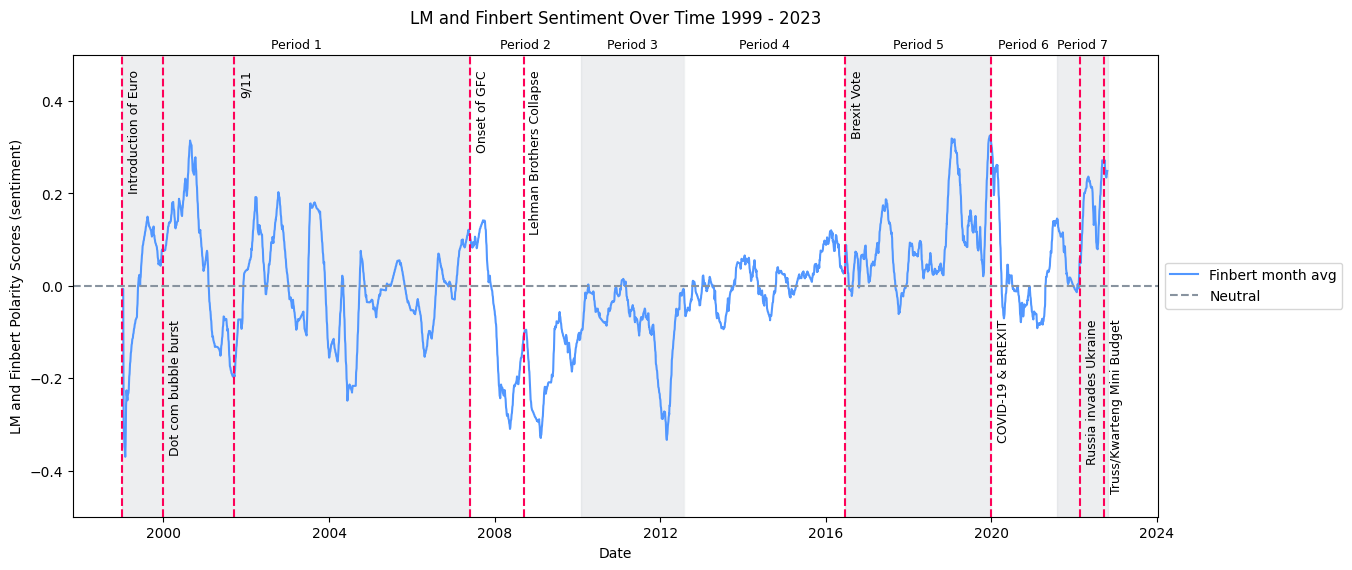

In [8]:
# Create line plots of finbert avgs
plt.figure(figsize=(14, 6))
finbert_plot = sns.lineplot(data=df, x='date',
                        y='finbert_rolling_avg',
                        color='#5297FF', label='Finbert month avg')

# Shade and label the periods
for i, (period, start_date, end_date) in enumerate(periods):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    midpoint = start_date + (end_date - start_date) / 2
    color = '#C4C9CE' if i % 2 == 0 else 'white'
    plt.axvspan(start_date, end_date, color=color, alpha=0.3)
    
    # Adjust y-coordinate for all periods
    y_coord = plt.gca().get_ylim()[1] * 1.45  # Move to the top of the plot
    plt.text(midpoint, y_coord, period,
             horizontalalignment='center',
             verticalalignment='center', fontsize=9)

for label, date in key_dates.items():
    date = pd.to_datetime(date)
    if label in ["Russia invades Ukraine", "Truss/Kwarteng Mini Budget",
                 "Dot com bubble burst", "COVID-19 & BREXIT"]:
        plt.axvline(date, color='#FE0158', linestyle='--')
        plt.text(x=date + pd.DateOffset(days=50),
                 y=plt.gca().get_ylim()[1] * -0.2,
                 s=label, rotation=90,
                 verticalalignment='top', fontsize=9)
    else:
        plt.axvline(date, color='#FE0158', linestyle='--')
        plt.text(x=date + pd.DateOffset(days=50),
                 y=plt.gca().get_ylim()[1] * 1.3,
                 s=label, rotation=90,
                 verticalalignment='top', fontsize=9)

# Add a dashed line for neutral sentiment
plt.axhline(y=0, color='#88939F',
            linestyle='--',
            label='Neutral')

# Set y-axis limits
plt.ylim(-0.5, 0.5) 

# Add legend outside
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Label plot
plt.xlabel('Date')
plt.ylabel('LM and Finbert Polarity Scores (sentiment)')
plt.title('LM and Finbert Sentiment Over Time 1999 - 2023', y=1.05)

# Save figure
plt.savefig('sentiment over time.png', bbox_inches='tight')

# Show
plt.show()

###

Can see the sentiment changing overtime - correlating particularly with global events.

Will look at the sentiment overtime in these time periods in a bit more detail below, remembering that these have been averaged so there could be quite a lot of range in speech sentiment on a more granular basis.

## 2.1) Sentiment by Period

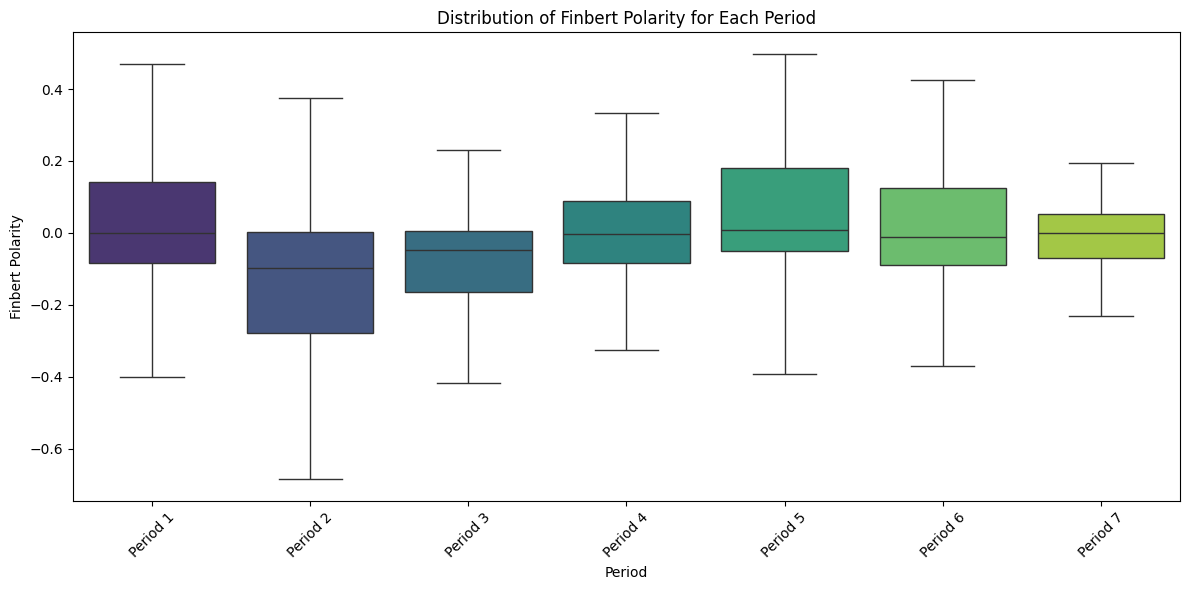

In [9]:
# Create an empty DataFrame to store the data
combined_df = pd.DataFrame(columns=['Period', 'Finbert Polarity'])

# Iterate over each period to create a DataFrame for 'finbert_polarity' within that period
for period, start_date, end_date in periods:
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    period_subset = df[(df['date'] >= start_date) & (df['date'] <= end_date) & df['boe_speech']]
    period_subset['Period'] = period
    combined_df = pd.concat([combined_df, 
                             period_subset[['Period', 'finbert_polarity']]],
                            ignore_index=True)

# Plotting the boxplot for each period
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='Period',
            y='finbert_polarity', palette='viridis',
            showfliers=False)

# Adding labels and title
plt.ylabel('Finbert Polarity')
plt.title('Distribution of Finbert Polarity for Each Period')

# Tidy plot
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
plt.savefig('Finbert by period', bbox_inches='tight')

# Show
plt.show()


Can see the sentiment changing over time, particularly with key global events e.g. GFC in Period 2, Russian invasion in Period 7.

HOWEVER, the range of sentiment in each of these periods is quite large. This could be due to the audience of the speeches, who was giving the speech etc.

Will now attempt to answer "How does the sentiment of the Bank of England’s speeches correlate with Bank rate decisions, including direction/magnitude of the change?"

## 3) Speech sentiment correlation with bank rate changes

In [10]:
# Calculate the change in bank rate from the previous day
df['bank_rate_change'] = df['base_rate'].diff()

# Display the updated DataFrame with percentage change values
df[['date', 'base_rate', 'bank_rate_change']].head()

,date,base_rate,bank_rate_change
0,1999-01-04,NaN,NaN
1,1999-01-05,NaN,NaN
2,1999-01-06,NaN,NaN
3,1999-01-07,6.0,NaN
4,1999-01-08,6.0,0.0


In [11]:
# Drop records with NaN values in 'bank_rate_pct_change' column
test = df.dropna(subset=['bank_rate_change'])

# Check
test.head()

,date,reference,country,title,author,is_gov,word_count,body,central_bank,year,...,gold_price,avg_house_price,1_mo_bond,10_yr_bond,2_yr_bond,unemployment,usd,wage_growth,finbert_rolling_avg,bank_rate_change
4,1999-01-08,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,293,72903.17681,6.019,4.252,4.810,6.2,1.6423,NaN,-0.007072,0.0
5,1999-01-11,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,295,72903.17681,6.030,4.298,4.790,6.2,1.6297,NaN,-0.007072,0.0
6,1999-01-12,r990112a_BOE,United Kingdom,Speech,George,False,2550,BOE,Bank of England,1999,...,290,72903.17681,6.029,4.357,4.775,6.2,1.6320,NaN,-0.112993,0.0
7,1999-01-13,r990112a_BOE,United Kingdom,Speech,George,False,2550,BOE,Bank of England,1999,...,288,72903.17681,5.836,4.277,4.797,6.2,1.6490,NaN,-0.192433,0.0
8,1999-01-14,r990112a_BOE,United Kingdom,Speech,George,False,2550,BOE,Bank of England,1999,...,288,72903.17681,5.825,4.260,4.755,6.2,1.6561,NaN,-0.254220,0.0


In [12]:
# How many bank rate step changes are there?
test['bank_rate_change'].nunique()

9

In [13]:
# Display the step changes
unique_values = test['bank_rate_change'].unique()
unique_values

array([ 0.  , -0.5 , -0.25,  0.25, -1.5 , -1.  , -0.15,  0.15,  0.5 ])

###

Will bucket these into categories as there's only a few examples at the extremes.

###

In [14]:
# Define a dictionary mapping bank_rate_change values to categories
category_mapping = {
    0.5: '>0.5',
    0.25: '0 to 0.5',
    0.15: '0 to 0.5',
    0: '0',
    -0.15: '0 to -0.5',
    -0.25: '0 to -0.5',
    -0.5: '0 to -0.5',
    -1: '<-0.5',
    -1.5: '<-0.5'}

# Create a new column 'bank_rate_category' by mapping 'bank_rate_change' values to categories
test['bank_rate_category'] = test['bank_rate_change'].map(category_mapping)

# View
test.head()

,date,reference,country,title,author,is_gov,word_count,body,central_bank,year,...,avg_house_price,1_mo_bond,10_yr_bond,2_yr_bond,unemployment,usd,wage_growth,finbert_rolling_avg,bank_rate_change,bank_rate_category
4,1999-01-08,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,72903.17681,6.019,4.252,4.810,6.2,1.6423,NaN,-0.007072,0.0,0
5,1999-01-11,r981215a_BOE,United Kingdom,Alice in Euroland,Buiter,False,4574,BOE,Bank of England,1998,...,72903.17681,6.030,4.298,4.790,6.2,1.6297,NaN,-0.007072,0.0,0
6,1999-01-12,r990112a_BOE,United Kingdom,Speech,George,False,2550,BOE,Bank of England,1999,...,72903.17681,6.029,4.357,4.775,6.2,1.6320,NaN,-0.112993,0.0,0
7,1999-01-13,r990112a_BOE,United Kingdom,Speech,George,False,2550,BOE,Bank of England,1999,...,72903.17681,5.836,4.277,4.797,6.2,1.6490,NaN,-0.192433,0.0,0
8,1999-01-14,r990112a_BOE,United Kingdom,Speech,George,False,2550,BOE,Bank of England,1999,...,72903.17681,5.825,4.260,4.755,6.2,1.6561,NaN,-0.254220,0.0,0


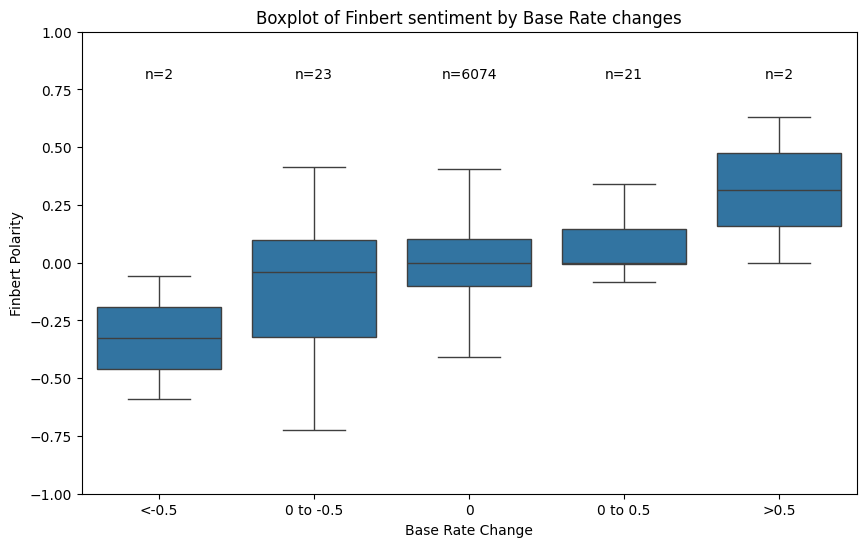

In [15]:
# Define the desired order of categories
category_order = ['<-0.5', '0 to -0.5', '0', '0 to 0.5', '>0.5']

# Create boxplots based on bank_rate_category with specified order
plt.figure(figsize=(10, 6))
sns.boxplot(data=test, x='bank_rate_category',
            y='finbert_polarity', order=category_order,
            showfliers=False)
plt.ylim(-1, 1)  # Set y-axis limits
plt.title('Boxplot of Finbert sentiment by Base Rate changes')
plt.xlabel('Base Rate Change')
plt.ylabel('Finbert Polarity')

# Count the number of records in each category
category_counts = test['bank_rate_category'].value_counts()

# Annotate each boxplot with the count
for i, count in enumerate(category_counts[category_order]):
    plt.text(i, 0.8, f'n={count}', ha='center', fontsize=10)

plt.show()

###

There is a broad trend in finbert polarity and base rate changes. However the following should be noted:

* There are only 2 records in the <-0.5 and >0.5 change bins,
* There is a range of sentiment expressed for all bins.

So although not expecting an excellent fit, will now look at quantifying this.

## 4) Can speech sentiment predict base rate change?

Will attempt simple linear regression on finbert_polarity and bank_rate_change and see how good it is before deciding if it's worth pursuing further.

#### Model 1 - all data

In [16]:
# Import statsmodel
import statsmodels.api as sm

# Prepare the data
# Independent variable (predictor)
X = test['finbert_polarity']  

# Dependent variable (response)
y = test['bank_rate_change'] 

# Add a constant for the intercept term
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       bank_rate_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.183
Date:                Sat, 13 Apr 2024   Prob (F-statistic):            0.00424
Time:                        12:31:04   Log-Likelihood:                 11748.
No. Observations:                6122   AIC:                        -2.349e+04
Df Residuals:                    6120   BIC:                        -2.348e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0006      0.000  

###

R-squared and Adjusted R-squared:

* The R-squared value indicates that approximately 0.1% of the variance in 'bank_rate_change' is explained by 'finbert_polarity'. This means that 'finbert_polarity' has very little explanatory power in predicting 'bank_rate_change'.

F-statistic and Prob (F-statistic):

* The F-statistic tests the overall significance of the regression model. Here, the F-statistic is 8.183 with a corresponding p-value of 0.00424. Since the p-value is less than 0.05, we reject the null hypothesis, suggesting that the regression model is statistically significant.

Coefficients:

* The coefficient of 'finbert_polarity' is 0.0052, indicating that for every one unit increase in 'finbert_polarity', 'bank_rate_change' is expected to increase by 0.0052 units.

* The constant term (intercept) is -0.0006, which represents the expected value of 'bank_rate_change' when 'finbert_polarity' is zero. 

P-values:

* The p-value associated with 'finbert_polarity' is 0.004, indicating that 'finbert_polarity' is statistically significant in predicting 'bank_rate_change' at the 0.05 significance level.

##### View the plot

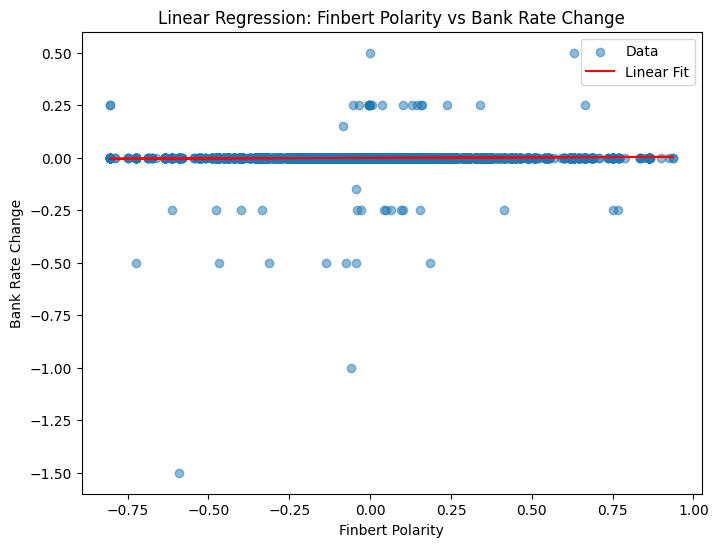

In [17]:
# Scatter plot of the data
plt.figure(figsize=(8, 6))
plt.scatter(test['finbert_polarity'], test['bank_rate_change'], alpha=0.5, label='Data')

# Plot the regression line
plt.plot(test['finbert_polarity'], model.predict(X), color='red', label='Linear Fit')

plt.title('Linear Regression: Finbert Polarity vs Bank Rate Change')
plt.xlabel('Finbert Polarity')
plt.ylabel('Bank Rate Change')
plt.legend()
plt.show()

###

Okay - that is interesting, there are so many times when bank rate doesn't change and therefore violates assumptions that theres a linear correlation. 

Options considered:

1) Remove the zeros and thus only consider the correlation when there IS a bank rate change. This will give some insight into how speech sentiment can predict the magnitude of a base rate change, BUT it will not offer any help ini determining if there WILL BE a bank rate change.
2) Use alternative regression models,
3) Transform the data.

With the time available, and to support the business question, "Does sentiment significantly change alongside macroeconomic indicators such as bank base?" the zeros will be removed. This is because internally within the bank it is known whether there will or will not be a base rate decision.

#### Model 2 - Remove 0 rate changes

In [18]:
# Remove rows with zero values in 'bank_rate_change'
non_zero_data = test[test['bank_rate_change'] != 0]

# Prepare the data for regression analysis
# Independent variable (predictor)
X = non_zero_data['finbert_polarity']

# Dependent variable (response)
y = non_zero_data['bank_rate_change']  

# Add a constant for the intercept term
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       bank_rate_change   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     4.118
Date:                Sat, 13 Apr 2024   Prob (F-statistic):             0.0482
Time:                        12:31:04   Log-Likelihood:                -21.306
No. Observations:                  48   AIC:                             46.61
Df Residuals:                      46   BIC:                             50.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0721      0.056  

###

R-squared and Adjusted R-squared:

* The R-squared value has increased to approximately 0.082 after removing zero values in 'bank_rate_change'. This means that around 8.2% of the variance in 'bank_rate_change' is explained by 'finbert_polarity'.

F-statistic and Prob (F-statistic):

* The F-statistic tests the overall significance of the regression model. Here, the F-statistic is 4.118 with a corresponding p-value of 0.0482. Since the p-value is less than 0.05, we reject the null hypothesis, suggesting that the regression model is statistically significant.

Coefficients:

* The coefficient of 'finbert_polarity' is 0.3217, indicating that for every one unit increase in 'finbert_polarity', 'bank_rate_change' is expected to increase by 0.3217 units.

* The constant term (intercept) is -0.0721, which represents the expected value of 'bank_rate_change' when 'finbert_polarity' is zero.

P-values:

* The p-value associated with 'finbert_polarity' is 0.048, indicating that 'finbert_polarity' is statistically significant in predicting 'bank_rate_change' at the 0.05 significance level.

##### View the plot

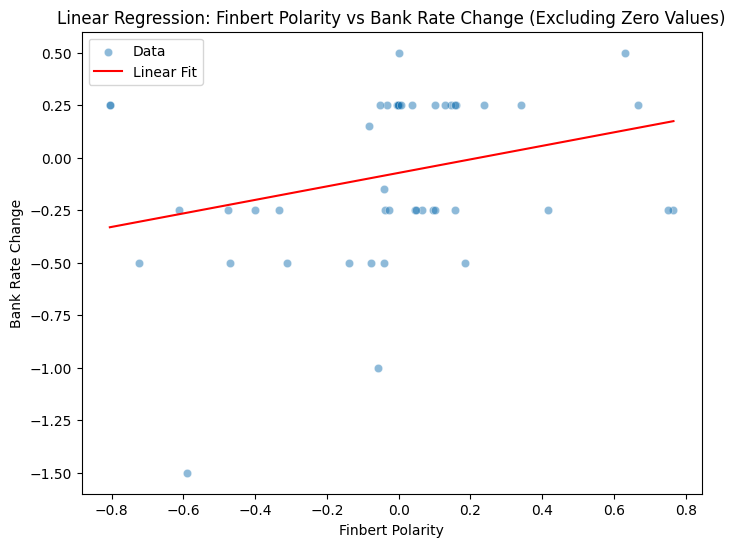

In [19]:
# Scatter plot of the data
plt.figure(figsize=(8, 6))
sns.scatterplot(data=non_zero_data, x='finbert_polarity', y='bank_rate_change', alpha=0.5, label='Data')
sns.lineplot(x=non_zero_data['finbert_polarity'], y=model.predict(X), color='red', label='Linear Fit')

# Labels
plt.title('Linear Regression: Finbert Polarity vs Bank Rate Change (Excluding Zero Values)')
plt.xlabel('Finbert Polarity')
plt.ylabel('Bank Rate Change')
plt.legend()

# Show
plt.show()

**Summary:** It's a better fit, but probably not worth using as the R-squared is so low. So many other factors are impacting if a base rate change is needed. Ultimately, the bank knows if they are going to move base rate, and have an idea of their speech sentiment, so not worth exploring any further. The work done to date here shows there is a slight correlation... unsurprising given that the bank does the speeches and base rate decisions.